In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from scripts import data_setup, data_acquisition, engine, predict
from pathlib import Path
from tqdm.auto import tqdm
from random import sample
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Latex

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0

In [3]:
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi_20%"
train_dir = image_path / "train"
test_dir = image_path /"test"

In [4]:
# Setup manual transforms as required in the ViT

manual_transforms = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [5]:
# This code cell can be used to download a dataset from a URL and extract it to a specified directory

# This is a smaller version of the Food101 dataset

# data_acquisition.acquire_data(image_path=image_path,
#                               url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
#                               zip_name = "pizza_steak_sushi_20%")

# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(data_dir=image_path,
#                                                                                train_transform=manual_transforms,
#                                                                                test_transform=manual_transforms,
#                                                                                batch_size=BATCH_SIZE,
#                                                                                num_workers=NUM_WORKERS)

In [6]:
# Obtain required dataset. This may be commented out and the cell may be run again to download the dataset from a URL

train_dataset = datasets.CIFAR10(root = data_path,
                                  train = True,
                                  transform = manual_transforms,
                                  download = True)
test_dataset = datasets.CIFAR10(root = data_path,
                                train = False,
                                transform = manual_transforms,
                                download = True)

# Setup the dataloaders

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Inspect our data

print(f"Number of train images: {len(train_dataset)}, Number of test images: {len(test_dataset)}\n")
print(f"Number of train batches: {len(train_dataloader)}, Number of test batches: {len(test_dataloader)}\n")
print(f"{len(train_dataset) // BATCH_SIZE} batches in the train dataloader expected and {len(test_dataset) // BATCH_SIZE} batches in the test dataloader expected.\nNote: This may not be exactly equal and may differ by 1 batch due to rounding off\n")
print(f"Classes: {class_names}")

Number of train images: 50000, Number of test images: 10000

Number of train batches: 1563, Number of test batches: 313

1562 batches in the train dataloader expected and 312 batches in the test dataloader expected.
Note: This may not be exactly equal and may differ by 1 batch due to rounding off

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


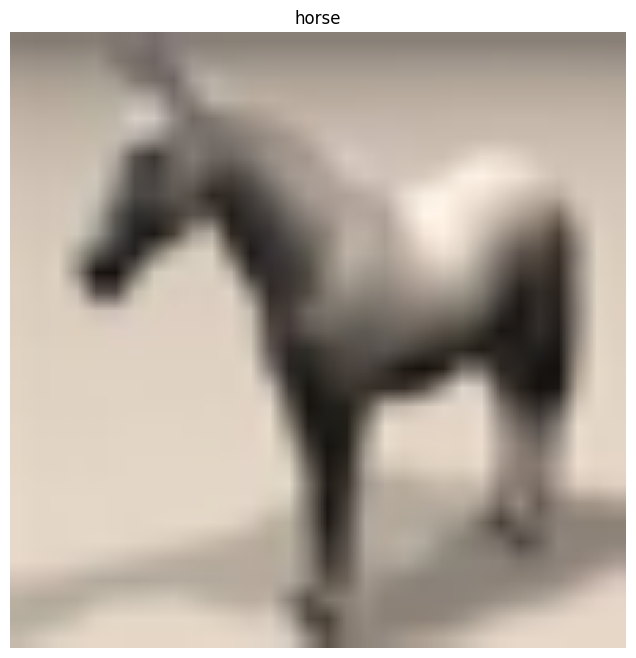

In [8]:
# Visualizing a single image
first_image_batch, first_label_batch = next(iter(train_dataloader))
random_image_index = torch.randint(low = 0, high = len(first_image_batch), size=(1,)).item()

random_image = first_image_batch[random_image_index]
random_label = first_label_batch[random_image_index].item()

plt.figure(figsize = (12,8))
plt.imshow(random_image.permute(1,2,0))
plt.title(class_names[random_label])
plt.axis(False)
plt.show()

### Study of equations

#### Equation 1

\begin{align}
\mathbf{z}_0=[\mathbf{x}_{\mathrm{class}}; \mathbf{x}_p^1\mathbf{E}; \mathbf{x}_p^2\mathbf{E};\cdots; \mathbf{x}_p^N\mathbf{E}]+\mathbf{E}_{pos}
\end{align}

is the first equation. Here, we compute the input to the transformer encoder. 
\begin{align}
\mathbf{x}_{\mathrm{class}} 
\end{align}
is a learnable class token
\begin{align}
\mathbf{x}_p^i
\end{align}
is the i-th patch embedding obtained from the linear projection of the flattened image
\begin{align}
\mathbf{E}_{pos}^i
\end{align}
is the positional embedding corresponding to the i-th patch position


#### Equation 2

The second euqation describes the multi-head self attention (MSA). MSA mechanism applies self-attention multiple times in parallel.

Attention is when a token focues on another token and an attention head is a single instance of the self-attention mechanism.

First, 3 learned projection matrices are used to compute the matrices for Queires(Q), Keys(K) and Values(V), where each matrix is of an embedding dimension d Then, attention is calculated as
\begin{align}
Attention(Q,K,V) = softmax(\dfrac{QK^T}{\sqrt{d_k}})V
\end{align}

Softmax is used to make sure all attention scores are positive and sum up to 1. Attention scores are used to compute a weighted sum of the values V.

In MSA, we apply self-attention multiple times in parallel using different learned projection matrices for each head. This allows the model to capture different aspects of the relationship between tokens. Then, the attention heads are concatenated.

The second equation is,
\begin{align}
\mathbf{z^{\prime}}_\ell=\mathrm{MSA}(\mathrm{LN}(\mathbf{z}_{\ell-1}))+\mathbf{z}_{\ell-1}
\end{align}


#### Equation 3

The third equation describes the MLP part of the ViT. It is a feedforward neural network and it operates on each token independantly.
\begin{align}
z_{l+1} = MLP(LN(z^{\prime}_l)) + z^{\prime}_l
\end{align}

The activatoin function used here is GELU.

#### Equation 4

The final equation is the normalization of the previous layer. This summarizes the previous layers

### Replication

First we take a look at patch embeddings. If data can be represented in a learnable way, it is much easier to train a model. Here we use patches of size 16\*16. The number of patches depends on the original size (which is 224\*244\*3 here)

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height * width) // (patch_size ** 2)
print(f"Number of patches for image of size {height}x{width} with patch size {patch_size}: {number_of_patches}")

Number of patches for image of size 224x224 with patch size 16: 196


In [12]:
embedding_layer_input_shape = (height, width, color_channels)
embegging_layer_output_shape = (number_of_patches, patch_size **2 * color_channels)

print(f"Input shape to embedding layer: {embedding_layer_input_shape}")
print(f"Output shape from embedding layer: {embegging_layer_output_shape}")

Input shape to embedding layer: (224, 224, 3)
Output shape from embedding layer: (196, 768)


### Converting a single image into patches